In [58]:
import pandas as pd
import requests
from pprint import pprint
from pandas.compat import StringIO
import matplotlib.pyplot as plt
import csv
import matplotlib 
from config import app_token 
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from sodapy import Socrata

client = Socrata("data.ny.gov", app_token)


In [59]:
#Get Motor Vehicle Information from 2014-2016
MotorVechileInfo= client.get("xe9x-a24f",limit=2000000)
motorvehiclecsv=pd.DataFrame.from_records(MotorVechileInfo)
motorvehiclecsv.to_csv("data_via_api_key.csv")
results_clean_df = motorvehiclecsv


In [60]:
#Data Cleansing
del results_clean_df["case_vehicle_id"]
del results_clean_df["partial_vin"]
# cleaning results_clean_df using notes from last session
results_clean_df1 = results_clean_df.loc[(results_clean_df.contributing_factor_1.notnull()) & (results_clean_df.contributing_factor_2.notnull()), :]
results_clean_df1 = results_clean_df1.loc[(results_clean_df1["action_prior_to_accident"] != "Unknown") &
                                         (results_clean_df1["contributing_factor_1_description"] != "Unknown") &
                                         (results_clean_df1["contributing_factor_2_description"] != "Unknown") &
                                         (results_clean_df1["event_type"] != "Unknown") &
                                         (results_clean_df1["vehicle_body_type"] != "UNKNOWN VEHICLE"),:]

results_clean_df1 = results_clean_df1.loc[(results_clean_df1["action_prior_to_accident"] != "Not Applicable") &
                                           (results_clean_df1["contributing_factor_1_description"] != "Not Entered") &
                                          (results_clean_df1["contributing_factor_2_description"] != "Not Entered") &
                                          (results_clean_df1["event_type"] != "Not Entered") &
                                          (results_clean_df1["vehicle_body_type"] != "Not Entered"), :]
results_clean_df1.to_csv("final_clean_data.csv")

In [61]:
action_prior_to_acc = pd.DataFrame({"vehicle_make": results_clean_df1["vehicle_make"], 
                                    "action_prior_to_accident": results_clean_df1["action_prior_to_accident"]})


action_prior_to_acc2 = action_prior_to_acc.groupby("vehicle_make").count().reset_index()

action_prior_to_acc2.sort_values("action_prior_to_accident",ascending=False, inplace=True)
action_prior_to_acc2.loc[action_prior_to_acc2["action_prior_to_accident"] > 20,:]
action_prior_to_acc3 = action_prior_to_acc2.loc[action_prior_to_acc2["action_prior_to_accident"] > 20,:]
                                    
vehicle_make_master_list = pd.DataFrame({"vehicle_make": action_prior_to_acc3["vehicle_make"]})

In [62]:


clean_master_data2 = pd.merge(results_clean_df1, vehicle_make_master_list, how = "inner", on="vehicle_make")
clean_master_data2.to_csv("clean_master_data2.csv")

In [63]:
cleansed=pd.read_csv("clean_master_data2.csv")
vehicleabbre=pd.read_csv("Vehicle_master_list.csv")
del cleansed["Unnamed: 0"]



In [64]:
#vehicleabbre is file has abbreviation and full name
vehiclemerge=pd.merge(cleansed,vehicleabbre,how="left",on="vehicle_make")
del vehiclemerge["vehicle_make"]
vehiclemergefinal=vehiclemerge.rename(columns={"vehicle_fullname":"vehicle_make"})
vehiclemergefinal.to_csv("Masterdatafullname.csv")

In [65]:
cleanseddata=pd.read_csv("clean_master_data2.csv")
vehiclecleansed = pd.read_csv("Masterdatafullname.csv")
del vehiclecleansed["Unnamed: 0"]


In [66]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}
plt.rc('font', **font)
csfont = {'fontweight':'bold','fontsize':'20'}
hsfont = {'fontsize':'13'}

In [67]:
#General Analyis

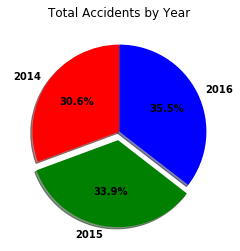

In [68]:
#Accidents over 3 years
accidents_in_2014 = cleanseddata.loc[cleanseddata["year"] == 2014]
accidents_in_2015 = cleanseddata.loc[cleanseddata["year"] == 2015]
accidents_in_2016 = cleanseddata.loc[cleanseddata["year"] == 2016]
total_2014 = len(accidents_in_2014)
total_2015 = len(accidents_in_2015)
total_2016 = len(accidents_in_2016)
slices_accidents = [total_2014, total_2015, total_2016]
years_values = [2014, 2015, 2016]
colors = ['r', 'g', 'b']
explode = (0,0.1,0)
plt.pie(slices_accidents, labels=years_values, colors=colors, startangle=90, autopct='%.1f%%', explode=explode, shadow=True)
plt.title("Total Accidents by Year")
plt.show()


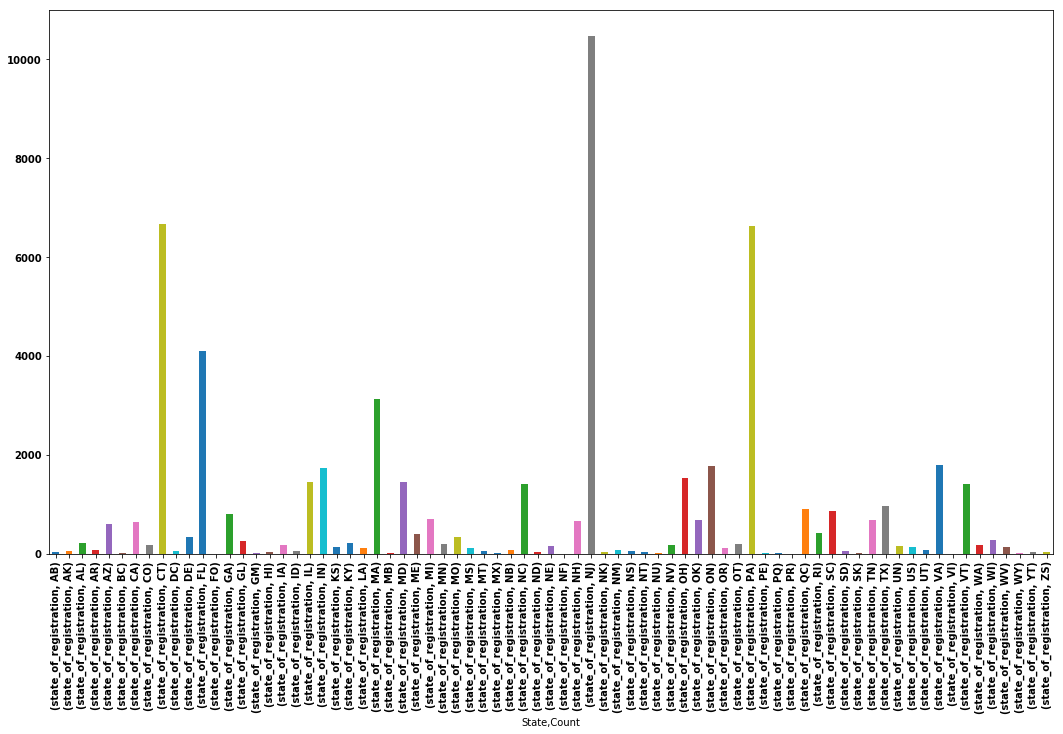

In [69]:
#Accidents caused based on state of vehicle registration
no_ny_df = cleanseddata[cleanseddata.state_of_registration != "NY"]
no_ny_df.dropna()
melted_data = pd.melt(no_ny_df, value_vars=['state_of_registration'], var_name='State', value_name='Count')
bar_data = melted_data.groupby(by=['State', 'Count'])['Count'].count()
my_plot = bar_data.plot(kind='bar',figsize = (18,10))

In [70]:
#Human as Primary Factor
accidents_human = cleanseddata.loc[cleanseddata["contributing_factor_1"] == "HUMAN"]

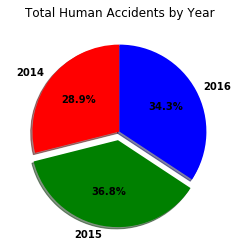

In [71]:
#1.	Total accidents over 3yrs with human as primary contributing factor.
accidents_human_2014 = accidents_human.loc[cleanseddata["year"] == 2014]
accidents_human_2015 = accidents_human.loc[cleanseddata["year"] == 2015]
accidents_human_2016 = accidents_human.loc[cleanseddata["year"] == 2016]
total_2014_human = len(accidents_human_2014)
total_2015_human = len(accidents_human_2015)
total_2016_human = len(accidents_human_2016)
slices_accidents_human = [total_2014_human, total_2015_human, total_2016_human]
years_values_human = [2014, 2015, 2016]
colors_human = ['r', 'g', 'b']
explode = (0,0.1,0)
plt.pie(slices_accidents_human, labels=years_values_human, colors=colors_human, startangle=90, autopct='%.1f%%', explode=explode, shadow = True)

plt.title("Total Human Accidents by Year")
plt.show()

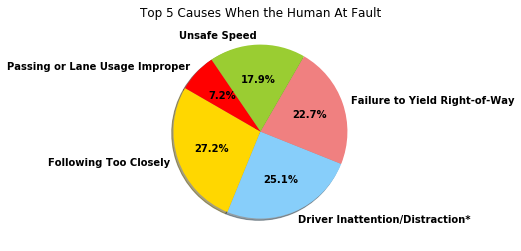

In [72]:
#2.	Top 10 primary accident factors (column: contributing_factor_1_description) for human as primary contributing factor combined for 3yrs
human_filt2 =accidents_human.loc[accidents_human["contributing_factor_1_description"] != "Not Applicable"]
human_cont = human_filt2["contributing_factor_1_description"].value_counts().nlargest(5)
plt.pie(human_cont,
        labels = ["Following Too Closely", "Driver Inattention/Distraction*", "Failure to Yield Right-of-Way", "Unsafe Speed","Passing or Lane Usage Improper"],
        colors=["gold","lightskyblue","lightcoral","yellowgreen","red"],
        autopct='%1.1f%%',
        shadow=True, startangle=150)
plt.title("Top 5 Causes When the Human At Fault")
plt.savefig("Top 5 Causes When the Human At Fault")


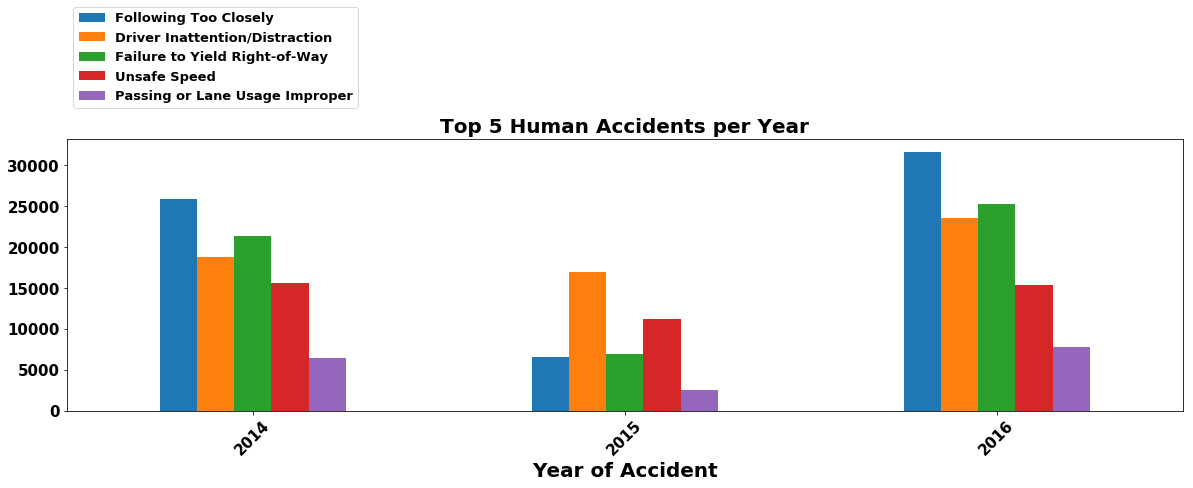

In [73]:
#3.	Trend for top 5 accident factors over 3yrs – whether the trend has increased/decreased and what does that convey
#Filter the total 3 year causes into per year
hum_2014 = human_filt2.loc[human_filt2["year"] == 2014]
hum_2015 = human_filt2.loc[human_filt2["year"] == 2015]
hum_2016 = human_filt2.loc[human_filt2["year"] == 2016]
#2014 count of top 5 accidents (Human)
a_2 = hum_2014[hum_2014["contributing_factor_1_description"] == "Following Too Closely"]["contributing_factor_1_description"].count()
a_3 = hum_2014[hum_2014["contributing_factor_1_description"] == "Driver Inattention/Distraction*"]["contributing_factor_1_description"].count()
a_4 = hum_2014[hum_2014["contributing_factor_1_description"] == "Failure to Yield Right-of-Way"]["contributing_factor_1_description"].count()
a_5 = hum_2014[hum_2014["contributing_factor_1_description"] == "Unsafe Speed"]["contributing_factor_1_description"].count()
a_6 = hum_2014[hum_2014["contributing_factor_1_description"] == "Passing or Lane Usage Improper"]["contributing_factor_1_description"].count()
#2015 count of top 5 accident (Human)
b_2 = hum_2015[hum_2015["contributing_factor_1_description"] == "Following Too Closely"]["contributing_factor_1_description"].count()
b_3 = hum_2015[hum_2015["contributing_factor_1_description"] == "Driver Inattention/Distraction*"]["contributing_factor_1_description"].count()
b_4 = hum_2015[hum_2015["contributing_factor_1_description"] == "Failure to Yield Right-of-Way"]["contributing_factor_1_description"].count()
b_5 = hum_2015[hum_2015["contributing_factor_1_description"] == "Unsafe Speed"]["contributing_factor_1_description"].count()
b_6 = hum_2015[hum_2015["contributing_factor_1_description"] == "Passing or Lane Usage Improper"]["contributing_factor_1_description"].count()
#2016 count of top 5 accident (Human)
c_2 = hum_2016[hum_2016["contributing_factor_1_description"] == "Following Too Closely"]["contributing_factor_1_description"].count()
c_3 = hum_2016[hum_2016["contributing_factor_1_description"] == "Driver Inattention/Distraction*"]["contributing_factor_1_description"].count()
c_4 = hum_2016[hum_2016["contributing_factor_1_description"] == "Failure to Yield Right-of-Way"]["contributing_factor_1_description"].count()
c_5 = hum_2016[hum_2016["contributing_factor_1_description"] == "Unsafe Speed"]["contributing_factor_1_description"].count()
c_6 = hum_2016[hum_2016["contributing_factor_1_description"] == "Passing or Lane Usage Improper"]["contributing_factor_1_description"].count()

#Create DataFrame from the value counts of top 5 causes and the distribution per year
humandf = pd.DataFrame({"Year": ["2014", "2015", "2016"], 
                        "Following Too Closely": [a_2, b_2, c_2],
                        "Driver Inattention/Distraction": [a_3, b_3, c_3], 
                        "Failure to Yield Right-of-Way": [a_4, b_4, c_4],
                       "Unsafe Speed":[a_5, b_5, c_5],
                       "Passing or Lane Usage Improper": [a_6, b_6, c_6]})
#Set the index and format and save chart 
d_t = humandf.set_index("Year")
d_t.plot(kind="bar",figsize=(20,5),legend=[],ax=plt.gca())
plt.tick_params(axis='x',  labelsize=15,rotation=45)
plt.tick_params(axis='y',  labelsize=15)
plt.legend(d_t,loc="center left",bbox_to_anchor=(0.0, 1.3),**hsfont)
plt.title("Top 5 Human Accidents per Year",**csfont)
plt.xlabel('Year of Accident',**csfont)
plt.savefig("Top 5 Human Accidents per Year")


Text(0.5, 0, 'Year of Accident')

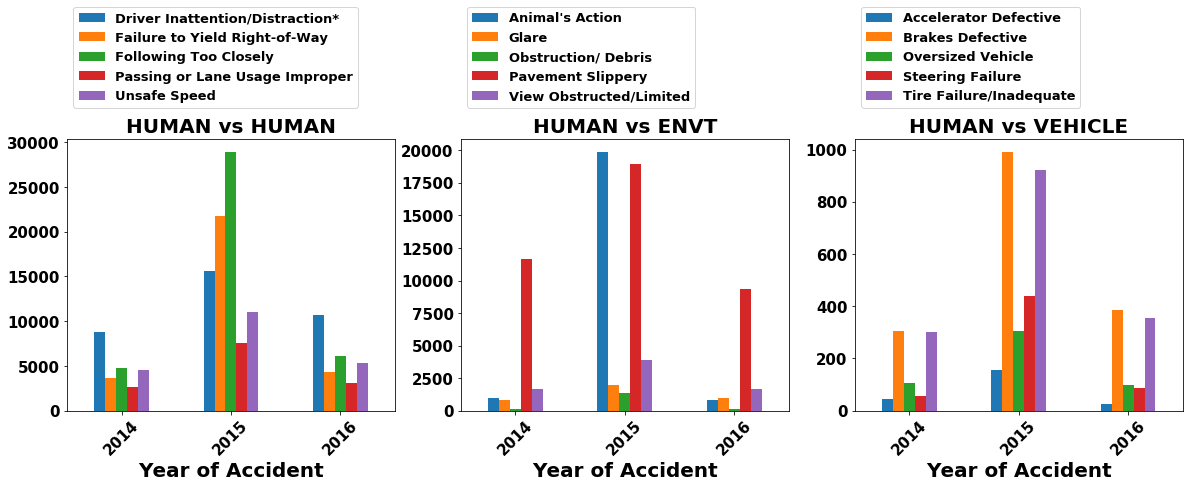

In [74]:
#4.	Human Vs Secondary factor categories (Human, Vehicle, Environment – column contributing_factor_2). Top 5 contributors from each secondary factor categories (column: contributing_factor_2_description) and their trend in last 3 yrs.

#What are top 5 contribution factor desceiption occurences over 3 years for each secondary contribution factor for "HUMAN" contribution factor

#take the combination of factor2 and description and get count without year
vehiclenoyear1=accidents_human.groupby(['contributing_factor_2','contributing_factor_2_description'],sort=True).agg({"contributing_factor_2_description":{"contributing_factor_2_descriptioncount": 'count'}})
vehiclenoyear1.columns=vehiclenoyear1.columns.map('_'.join)

vehiclenoyear1.rename(columns={"contributing_factor_2_description_contributing_factor_2_descriptioncount":"contributing_factor_2_descriptioncount"},inplace=True)
vehiclenoyear3=vehiclenoyear1.reset_index()


#take the combination of factor2 and description and get count with year
vehiclecleansed1=accidents_human.groupby(['contributing_factor_2','contributing_factor_2_description','year'],sort=True).agg({"contributing_factor_2_description":{"contributing_factor_2_descriptioncount": 'count'}})
vehiclecleansed1.columns=vehiclecleansed1.columns.map('_'.join)

vehiclecleansed1.rename(columns={"contributing_factor_2_description_contributing_factor_2_descriptioncount":"contributing_factor_2_descriptioncount"},inplace=True)
vehiclecleansed3=vehiclecleansed1.reset_index()
#drop rows where description has no meaning(drop.index will remove the rows by thier specific position)
#sort on factor2 and count to get factor descriptions  caused more accidents in descending order
#group by and head(5) will give top 5 records within each group
vehiclecleansed4=vehiclenoyear3.drop(vehiclenoyear3[vehiclenoyear3["contributing_factor_2_description"] == "Not Entered"].index).drop(vehiclenoyear3[vehiclenoyear3["contributing_factor_2_description"] == "Other*"].index).drop(vehiclenoyear3[vehiclenoyear3["contributing_factor_2_description"] == "Not Applicable"].index).sort_values(['contributing_factor_2','contributing_factor_2_descriptioncount'], ascending=[False,False]).groupby("contributing_factor_2").head(5)
#vehiclecleansed4 has top contibution factors with count for all years together for each factor description.As we need the count for each year  We merge this with vehiclecleansed3 which has count for each year
#Merge to get what is the count for each year for each of the factor description in vehiclecleansed4 
vehiclecleansed5=pd.merge(vehiclecleansed3,vehiclecleansed4,on="contributing_factor_2_description")
#del vehiclecleansed5["year_y"]
del vehiclecleansed5["contributing_factor_2_descriptioncount_y"]
del vehiclecleansed5["contributing_factor_2_y"]
#vehiclenoyear3
vehiclecleansed5.rename(columns={"contributing_factor_2_x":"contributing_factor_2","contributing_factor_2_descriptioncount_x":"contributing_factor_2_descriptioncount"},inplace=True)
vehiclecleansed6=vehiclecleansed5.groupby(["contributing_factor_2","contributing_factor_2_description","year","contributing_factor_2_descriptioncount"]).count()

vehiclecleansed7=vehiclecleansed6.reset_index()
#filter on each contibution factor and get all the columns 
vehiclecleansedHUMAN=vehiclecleansed7.loc[vehiclecleansed7["contributing_factor_2"]=="HUMAN",:]
vehiclecleansedENV=vehiclecleansed7.loc[vehiclecleansed7["contributing_factor_2"]=="ENVMT",:]
vehiclecleansedVEH=vehiclecleansed7.loc[vehiclecleansed7["contributing_factor_2"]=="VEHICLE",:]
vehiclecleansedHUMgr=vehiclecleansedHUMAN.groupby(["year","contributing_factor_2_description","contributing_factor_2_descriptioncount"]).count()
vehiclecleansedENVgr=vehiclecleansedENV.groupby(["year","contributing_factor_2_description","contributing_factor_2_descriptioncount"]).count()
vehiclecleansed2VEHgr=vehiclecleansedVEH.groupby(["year","contributing_factor_2_description","contributing_factor_2_descriptioncount"]).count()
#as dataframe has this column groupby.count gives count on this column. Remove this column

del vehiclecleansedHUMgr["contributing_factor_2"]
del vehiclecleansedENVgr["contributing_factor_2"]
del vehiclecleansed2VEHgr["contributing_factor_2"]
#We need to plot the values on description count. So make it as column
vehiclecleansedHUMgrre=vehiclecleansedHUMgr.reset_index('contributing_factor_2_descriptioncount')
vehiclecleansedENVgrre=vehiclecleansedENVgr.reset_index('contributing_factor_2_descriptioncount')
vehiclecleansed2VEHgrre=vehiclecleansed2VEHgr.reset_index('contributing_factor_2_descriptioncount')

matplotlib.rc('font', **font)


#unstack to bring factor description values as column names. For each description column will have corresponding count for each year. 
#plt.gca() will plot the graph at axis (1st row ,1st coumn out of 3)

#unstack and plot on this unstacked contributionfactor descriptions is giving names enclosed in (). To make it proper names first take off legends and get names from the column

plt.subplot(1,3,1)
vehiclecleansedHUMgrre.unstack("contributing_factor_2_description").plot(kind="bar",figsize=(20,5),legend=[],ax=plt.gca())
plt.tick_params(axis='x',  labelsize=15,rotation=45)
plt.tick_params(axis='y',  labelsize=15)
#without bbox_to_anchor labels are overlapping with bars. So using this placed legends out of box. It will create the box at specific positon and inside the box alightn the labels based on loc parameter
plt.legend(vehiclecleansedHUMAN["contributing_factor_2_description"].unique(),loc="center left",bbox_to_anchor=(0.0, 1.3),**hsfont)

plt.title("HUMAN vs HUMAN",**csfont)
plt.xlabel('Year of Accident',**csfont)

plt.subplot(1,3,2)
#plt.gca() will plot the graph at axis (1st row ,2ndcoumn out of 3)
vehiclecleansedENVgrre.unstack("contributing_factor_2_description").plot(kind="bar",figsize=(20,5),legend=[],ax=plt.gca())
plt.tick_params(axis='x',  labelsize=15,rotation=45)
plt.tick_params(axis='y',  labelsize=15)
plt.legend(vehiclecleansedENV["contributing_factor_2_description"].unique(),loc="center left",bbox_to_anchor=(0.0, 1.3),**hsfont)
plt.title("HUMAN vs ENVT",**csfont)
plt.xlabel('Year of Accident',**csfont)
plt.subplot(1,3,3)
#plt.gca() will plot the graph at axis (1st row ,3rd coumn out of 3)
vehiclecleansed2VEHgrre.unstack("contributing_factor_2_description").plot(kind="bar",figsize=(20,5),legend=[],ax=plt.gca())
plt.tick_params(axis='x',  labelsize=15,rotation=45)
plt.tick_params(axis='y',  labelsize=15)
plt.legend(vehiclecleansedVEH["contributing_factor_2_description"].unique(),loc="center left",bbox_to_anchor=(0.0, 1.3),**hsfont)
plt.title("HUMAN vs VEHICLE",**csfont)
plt.xlabel('Year of Accident',**csfont)


In [75]:
#Vehicle Analysis
accidents_vehicle = vehiclecleansed.loc[vehiclecleansed["contributing_factor_1"] == "VEHICLE"]


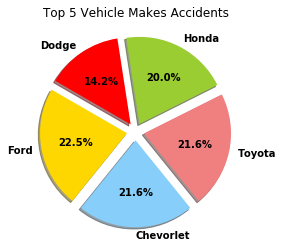

In [76]:
#1-- top 5 brands of vehicles with the most accidnets without vehicle filter

vehicle_count = pd.DataFrame(vehiclecleansed.groupby(["vehicle_make"])["action_prior_to_accident"].count())
table = pd.DataFrame({"Vehicle Make Count": vehicle_count ['action_prior_to_accident']})
#puts in order so top results appear first 
table = table.sort_values("Vehicle Make Count", ascending=False)


#turns the top 5 into a variable 
table1=table.head(5)
vehicle_count=table1["Vehicle Make Count"]
# creates pie chart 

plt.pie(vehicle_count,
        labels=["Ford","Chevorlet","Toyota","Honda","Dodge"],
        colors=["gold","lightskyblue","lightcoral","yellowgreen","red"],
        autopct='%1.1f%%',
        explode = (0.1, 0.1, 0.1, 0.1, 0.1),
        shadow=True, startangle=150)

#creates title 
plt.title('Top 5 Vehicle Makes Accidents')


#saves as png 

plt.savefig("Top 5 Vehicle Makes with Accidents No filter.png")


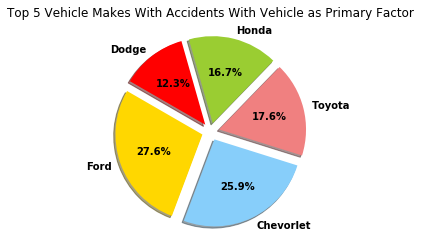

In [77]:
#1---- top 5 brands of vehicles with the most accidnets with vehicle filter
vehicle_count = pd.DataFrame(accidents_vehicle.groupby(["vehicle_make"])["action_prior_to_accident"].count())
table = pd.DataFrame({"Vehicle Make Count": vehicle_count ['action_prior_to_accident']})
#puts in order so top results appear first 
table = table.sort_values("Vehicle Make Count", ascending=False)


#turns the top 5 into a variable 
table1=table.head(5)
vehicle_count=table1["Vehicle Make Count"]
# creates pie chart 

plt.pie(vehicle_count,
        labels=["Ford","Chevorlet","Toyota","Honda","Dodge"],
        colors=["gold","lightskyblue","lightcoral","yellowgreen","red"],
        autopct='%1.1f%%',
        explode = (0.1, 0.1, 0.1, 0.1, 0.1),
        shadow=True, startangle=150)

#creates title 
plt.title('Top 5 Vehicle Makes With Accidents With Vehicle as Primary Factor')


#saves as png 

plt.savefig("Top 5 Vehicle Makes with Accidents with filter.png")

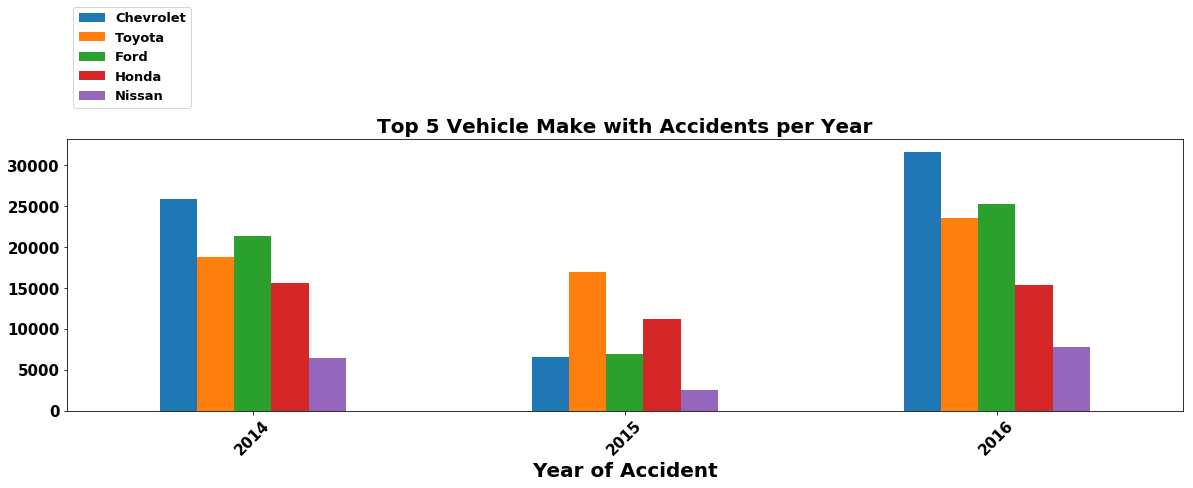

In [78]:
#2.	Accident trend for top 5 of above brands in 3 yrs – whether accidents have increased/decreased/remained the same

veh_cont = accidents_vehicle["vehicle_make"].value_counts().nlargest(5)
#Fiter each to car then by year
chev = accidents_vehicle.loc[accidents_vehicle["vehicle_make"] == "Chevrolet"]
chevy_14 = chev.loc[chev["year"] == 2014]
chevy_15 = chev.loc[chev["year"] == 2015]
chevy_16 = chev.loc[chev["year"] == 2016]

toy = accidents_vehicle.loc[accidents_vehicle["vehicle_make"] == "Toyota"]
toyo_14 = toy.loc[toy["year"] == 2014]
toyo_15 = toy.loc[toy["year"] == 2015]
toyo_16 = toy.loc[toy["year"] == 2016] 

ford = accidents_vehicle.loc[accidents_vehicle["vehicle_make"] == "Ford"]
ford_14 = ford.loc[ford["year"] == 2014]
ford_15 = ford.loc[ford["year"] == 2015]
ford_16 = ford.loc[ford["year"] == 2016]

hon = accidents_vehicle.loc[accidents_vehicle["vehicle_make"] == "Honda"]
hon_14 = hon.loc[hon["year"] == 2014]
hon_15 = hon.loc[hon["year"] == 2015]
hon_16 = hon.loc[hon["year"] == 2016]

niss = accidents_vehicle.loc[accidents_vehicle["vehicle_make"] == "Nissan"]
niss_14 = niss.loc[niss["year"] == 2014]
niss_15 = niss.loc[niss["year"] == 2015]
niss_16 = niss.loc[niss["year"] == 2016]
#Get value count for each of the top 5 cars per year
chev_2014 = chevy_14["vehicle_make"].count()
chev_2015 = chevy_15["vehicle_make"].count()
chev_2016 = chevy_16["vehicle_make"].count()

toy_2014 = toyo_14["vehicle_make"].count()
toy_2015 = toyo_15["vehicle_make"].count()
toy_2016 = toyo_16["vehicle_make"].count()

ford_2014 = ford_14["vehicle_make"].count()
ford_2015 = ford_15["vehicle_make"].count()
ford_2016 = ford_16["vehicle_make"].count()

hon_2014 = hon_14["vehicle_make"].count()
hon_2015 = hon_15["vehicle_make"].count()
hon_2016 = hon_16["vehicle_make"].count()

niss_2014 = niss_14["vehicle_make"].count()
niss_2015 = niss_15["vehicle_make"].count()
niss_2016 = niss_16["vehicle_make"].count()

#Create dataframe using value counts 
veh_make = pd.DataFrame({"Year": ["2014", "2015", "2016"], 
                        "Chevrolet": [chev_2014, chev_2015, chev_2016],
                         "Toyota": [toy_2014, toy_2015, toy_2016], 
                        "Ford": [ford_2014, ford_2015, ford_2016],
                       "Honda": [hon_2014, hon_2015, hon_2016],
                       "Nissan": [niss_2014, niss_2015, niss_2016]})
#Set index and format and save figure
v_m = veh_make.set_index("Year")
plt.rc('font', **font)
d_t.plot(kind="bar",figsize=(20,5),legend=[],ax=plt.gca())
plt.tick_params(axis='x',  labelsize=15,rotation=45)
plt.tick_params(axis='y',  labelsize=15)
plt.legend(v_m,loc="center left",bbox_to_anchor=(0.0, 1.3),**hsfont)
plt.title("Top 5 Vehicle Make with Accidents per Year",**csfont)
plt.xlabel('Year of Accident',**csfont)
plt.savefig("Top 5 Vehicle Make with Accidents per Year")

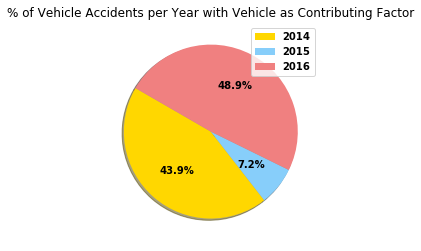

In [79]:
#3.	Spread of accidents in 3yrs

veh_count = accidents_vehicle.groupby("year").count()["action_prior_to_accident"]
veh_sum = (accidents_vehicle.groupby("year").count()["action_prior_to_accident"]/accidents_vehicle["action_prior_to_accident"].count()) *100 
#plot % of vehicle accidents per year 
plt.pie(veh_sum,
        colors=["gold","lightskyblue","lightcoral"],
        autopct='%1.1f%%',
        shadow=True, startangle=150)
plt.title('% of Vehicle Accidents per Year with Vehicle as Contributing Factor')

#create legend from the array 
labels=["2014","2015","2016"]
plt.legend(labels, loc="upper right")

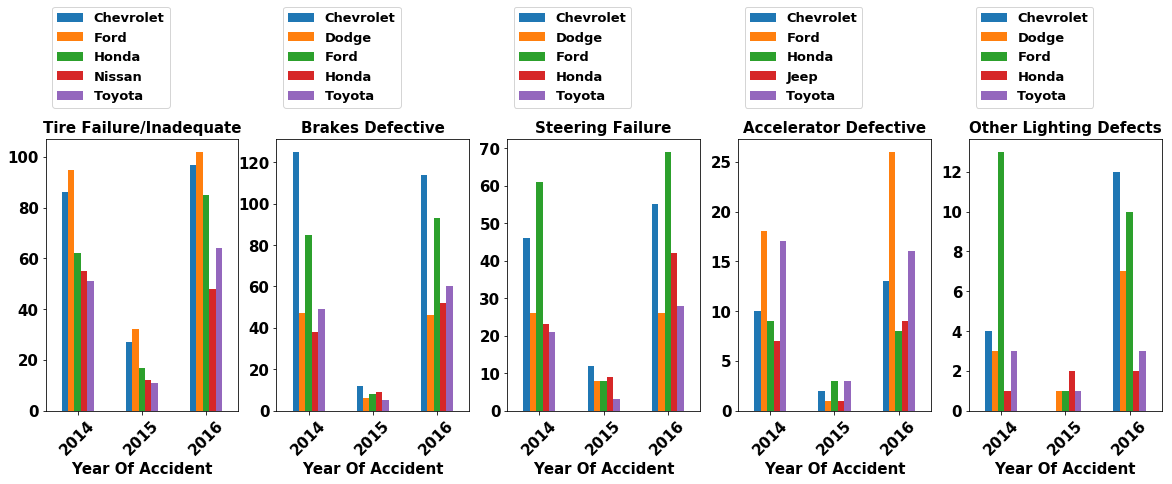

In [80]:
#vehicle4 analysis
#Whate are top 5 vehcile make occurences for top 5 primary contibution factors for each year with "VEHICLE" as primary contribution factor

def contributionfact(contibufact,num,condesc):
    
    #top 5 vehicle makes for factor desc 
    contibufactnoyear=contibufact.groupby('vehicle_make').agg({"contributing_factor_1_description":{"contributing_factor_1_descriptioncount": 'count'}})
    
    contibufactnoyear.columns=contibufactnoyear.columns.map('_'.join)
    
    contibufactnoyear.rename(columns={"contributing_factor_1_description_contributing_factor_1_descriptioncount":"contributing_factor_1_descriptioncount"},inplace=True)
    contibufactnoyear1=contibufactnoyear.reset_index()
   
    contibufactnoyear2=contibufactnoyear1.sort_values("contributing_factor_1_descriptioncount",ascending=False).head(5)
    
#for  factor desc5 count of  vehcile_makes for each year 

    contibufactyear=contibufact.groupby(['vehicle_make','year']).agg({"contributing_factor_1_description":{"contributing_factor_1_descriptioncount": 'count'}})
    
    contibufactyear.columns=contibufactyear.columns.map('_'.join)

    contibufactyear.rename(columns={"contributing_factor_1_description_contributing_factor_1_descriptioncount":"contributing_factor_1_descriptioncount"},inplace=True)
    contibufactyear1=contibufactyear.reset_index()
    
#merge two data sets to get number of occurences of vechile by year for fact desc 5
    contibufactyearmerge1=pd.merge(contibufactyear1,contibufactnoyear2,on="vehicle_make")

    del contibufactyearmerge1["contributing_factor_1_descriptioncount_y"]
    contibufactyearmerge1.rename(columns={'contributing_factor_1_descriptioncount_x':'contributing_factor_1_descriptioncount'},inplace=True)
    plotgraph(contibufactyearmerge1,num,condesc)
def plotgraph(contibufactyearmerge1,num,condesc):   
    #just to have these columns in the table I had to provide aggregate function on atleast one column
    contibufactyearmergegrp=contibufactyearmerge1.groupby(['year','vehicle_make','contributing_factor_1_descriptioncount']).agg({"contributing_factor_1_descriptioncount": 'count'})
    #as both index and column have same name to drop the column later renamed it
    contibufactyearmergegrpren=contibufactyearmergegrp.rename(columns={"contributing_factor_1_descriptioncount":"contritmp"})
    del contibufactyearmergegrpren["contritmp"]
    contibufactyearmergegrprenres=contibufactyearmergegrpren.reset_index("contributing_factor_1_descriptioncount")
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}
    matplotlib.rc('font', **font)
    csfont = {'fontweight':'bold','fontsize':'15'}
    hsfont = {'fontsize':'13'}
    plt.subplot(1,5,num)
    contibufactyearmergegrprenres.unstack("vehicle_make").plot(kind="bar",figsize=(20,5),legend=[],ax=plt.gca())
    plt.tick_params(axis='x',  labelsize=15,rotation=45)
    plt.tick_params(axis='y',  labelsize=15)
    plt.legend(contibufactyearmerge1["vehicle_make"].unique(),loc="center left",bbox_to_anchor=(0.0, 1.3),**hsfont)
    plt.title(condesc,**csfont)
    plt.xlabel("Year Of Accident",**csfont)
#function ends  


vehiclenoyear1=accidents_vehicle.groupby(['contributing_factor_1_description']).agg({"contributing_factor_1_description":{"contributing_factor_1_descriptioncount": 'count'}})
vehiclenoyear1.columns=vehiclenoyear1.columns.map('_'.join)

vehiclenoyear1.rename(columns={"contributing_factor_1_description_contributing_factor_1_descriptioncount":"contributing_factor_1_descriptioncount"},inplace=True)
vehiclenoyear3=vehiclenoyear1.reset_index()
vehiclecleansed4=vehiclenoyear3.drop(vehiclenoyear3[vehiclenoyear3["contributing_factor_1_description"] == "Driverless/Runaway Vehicle"].index).drop(vehiclenoyear3[vehiclenoyear3["contributing_factor_1_description"] == "Oversized Vehicle"].index).drop(vehiclenoyear3[vehiclenoyear3["contributing_factor_1_description"] == "Not Entered"].index).drop(vehiclenoyear3[vehiclenoyear3["contributing_factor_1_description"] == "Other*"].index).drop(vehiclenoyear3[vehiclenoyear3["contributing_factor_1_description"] == "Not Applicable"].index).sort_values(['contributing_factor_1_descriptioncount'], ascending=[False]).head(5)
factordesc=vehiclecleansed4['contributing_factor_1_description'].values.tolist()

#create seperate datasets of records with each top 5 descriptions

contibufact1 = accidents_vehicle.loc[vehiclecleansed['contributing_factor_1_description']==factordesc[0]]
contributionfact(contibufact1,1,factordesc[0])
contibufact2 = accidents_vehicle.loc[vehiclecleansed['contributing_factor_1_description']==factordesc[1]]
contributionfact(contibufact2,2,factordesc[1])
contibufact3 = accidents_vehicle.loc[vehiclecleansed['contributing_factor_1_description']==factordesc[2]]
contributionfact(contibufact3,3,factordesc[2])
contibufact4 = accidents_vehicle.loc[vehiclecleansed['contributing_factor_1_description']==factordesc[3]]

contributionfact(contibufact4,4,factordesc[3])
contibufact5 = accidents_vehicle.loc[vehiclecleansed['contributing_factor_1_description']==factordesc[4]]
contributionfact(contibufact5,5,factordesc[4])


In [81]:
#vehicle 5
fonth = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **fonth)
csfonth = {'fontweight':'bold','fontsize':'15'}
hsfonth = {'fontsize':'13'}

In [82]:
master_df = pd.read_csv("Masterdatafullname.csv")
vehicle_master = master_df[master_df["contributing_factor_1"] == "VEHICLE"]
ignore_list = ["Other*", "Not Applicable"]
vehicle_master = vehicle_master[~vehicle_master["contributing_factor_2_description"].isin(ignore_list)]
del vehicle_master["Unnamed: 0"]
vehicle_master.head()

,action_prior_to_accident,contributing_factor_1,contributing_factor_1_description,contributing_factor_2,contributing_factor_2_description,direction_of_travel,engine_cylinders,event_type,fuel_type,number_of_occupants,registration_class,state_of_registration,type_axles_of_truck_or_bus,vehicle_body_type,vehicle_year,year,vehicle_make
83,Slowing or Stopping,VEHICLE,Brakes Defective,VEHICLE,Tire Failure/Inadequate,East,NaN,Not Applicable,Not Entered,1.0,Not Entered,GL,Not Entered,DELIVERY TRUCK,1990.0,2015,Grumman
298,Going Straight Ahead,VEHICLE,Brakes Defective,HUMAN,Following Too Closely,West,NaN,Not Applicable,Not Entered,2.0,Not Entered,NY,Not Entered,4 DOOR SEDAN,1999.0,2014,Toyota
1246,Going Straight Ahead,VEHICLE,Other*,ENVMT,Animal's Action,North,NaN,"Guide Rail - Not At End, Collision With Fixed ...",Not Entered,3.0,Not Entered,PA,Not Entered,4 DOOR SEDAN,1999.0,2014,Toyota
1338,Going Straight Ahead,VEHICLE,Other*,HUMAN,Unsafe Lane Changing,South,NaN,Not Applicable,Not Entered,3.0,Not Entered,PA,Not Entered,4 DOOR SEDAN,2010.0,2014,Toyota
2006,Going Straight Ahead,VEHICLE,Steering Failure,HUMAN,Driver Inattention/Distraction*,Southwest,NaN,Not Applicable,Not Entered,1.0,Not Entered,MA,Not Entered,4 DOOR SEDAN,2015.0,2016,Toyota


In [83]:
#vehicle5 Vehicle vs environment
# Graph plot for Primary cause of accident as Vehicle Factor and secondary cause as environmental factor
#plotting top 5 environmental causes

#vehicle vs environment
vehicle_vs_envmt = vehicle_master[vehicle_master["contributing_factor_2"] == "ENVMT"].groupby("contributing_factor_2_description").count().sort_values("action_prior_to_accident", ascending = False).head()
vehicle_vs_envmt = vehicle_vs_envmt.drop(list(vehicle_vs_envmt.columns)[1:17], axis = 1)
vehicle_vs_envmt_top5 = vehicle_master[vehicle_master["contributing_factor_2"] == "ENVMT"]
vehicle_vs_envmt_top5 = vehicle_vs_envmt_top5[vehicle_vs_envmt_top5["contributing_factor_2_description"].isin(vehicle_vs_envmt.index)]
vehicle_vs_envmt_3yrs = vehicle_vs_envmt_top5.groupby(["contributing_factor_2_description", "year"], sort = True).count()
vehicle_vs_envmt_3yrs = vehicle_vs_envmt_3yrs.drop(list(vehicle_vs_envmt_3yrs.columns)[1:17], axis = 1)
vehicle_vs_envmt_3yrs_list = vehicle_vs_envmt_3yrs.unstack("year")

# vehicle vs human
vehicle_vs_human = vehicle_master[vehicle_master["contributing_factor_2"] == "HUMAN"].groupby("contributing_factor_2_description").count().sort_values("action_prior_to_accident", ascending = False).head()
vehicle_vs_human = vehicle_vs_human.drop(list(vehicle_vs_human.columns)[1:17], axis = 1)
vehicle_vs_human_top5 = vehicle_master[vehicle_master["contributing_factor_2"] == "HUMAN"]
vehicle_vs_human_top5 = vehicle_vs_human_top5[vehicle_vs_human_top5["contributing_factor_2_description"].isin(vehicle_vs_human.index)]
vehicle_vs_human_3yrs = vehicle_vs_human_top5.groupby(["contributing_factor_2_description", "year"], sort = True).count()
vehicle_vs_human_3yrs = vehicle_vs_human_3yrs.drop(list(vehicle_vs_human_3yrs.columns)[1:17], axis = 1)
vehicle_vs_human_3yrs_list = vehicle_vs_human_3yrs.unstack("year")

# vehicle vs vehicle
vehicle_vs_vehicle = vehicle_master[vehicle_master["contributing_factor_2"] == "VEHICLE"].groupby("contributing_factor_2_description").count().sort_values("action_prior_to_accident", ascending = False).head()
vehicle_vs_vehicle = vehicle_vs_vehicle.drop(list(vehicle_vs_vehicle.columns)[1:17], axis = 1)
vehicle_vs_vehicle_top5 = vehicle_master[vehicle_master["contributing_factor_2"] == "VEHICLE"]
vehicle_vs_vehicle_top5 = vehicle_vs_vehicle_top5[vehicle_vs_vehicle_top5["contributing_factor_2_description"].isin(vehicle_vs_vehicle.index)]
vehicle_vs_vehicle_3yrs = vehicle_vs_vehicle_top5.groupby(["contributing_factor_2_description", "year"], sort = True).count()
vehicle_vs_vehicle_3yrs = vehicle_vs_vehicle_3yrs.drop(list(vehicle_vs_vehicle_3yrs.columns)[1:17], axis = 1)
vehicle_vs_vehicle_3yrs_list = vehicle_vs_vehicle_3yrs.unstack("year")


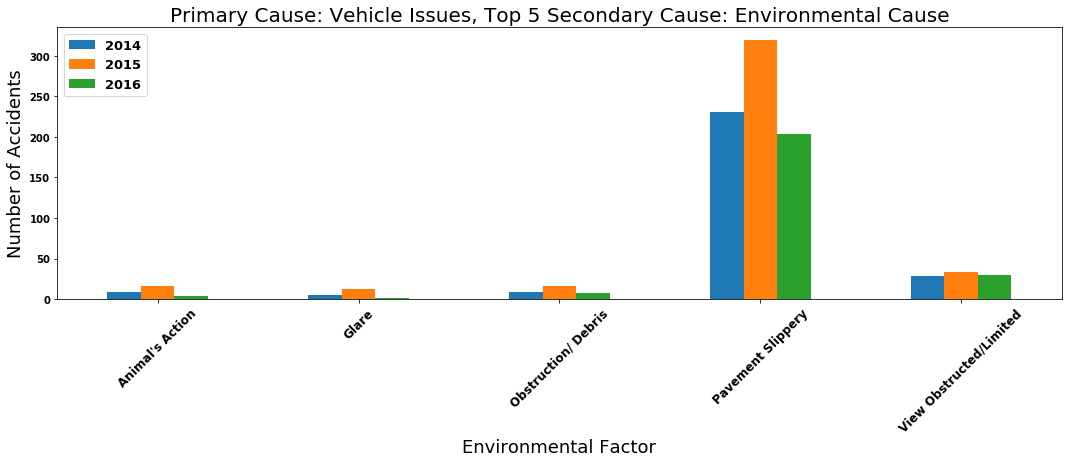

In [84]:
vehicle_vs_envmt = vehicle_vs_envmt_3yrs_list.plot(kind = "bar", figsize = (18,5), align = "center", legend = [])
plt.xlabel("Environmental Factor", fontsize=18)
plt.ylabel("Number of Accidents", fontsize=18)
plt.tick_params(axis='x', labelsize= 12, rotation=45 )
plt.title("Primary Cause: Vehicle Issues, Top 5 Secondary Cause: Environmental Cause", fontsize=20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.05))
plt.legend(vehicle_vs_envmt_3yrs_list["action_prior_to_accident"],loc="upper left",**hsfont)
vehicle_vs_envmt
plt.savefig("Vehicle_Issues_And_Environmental_Cause.png")

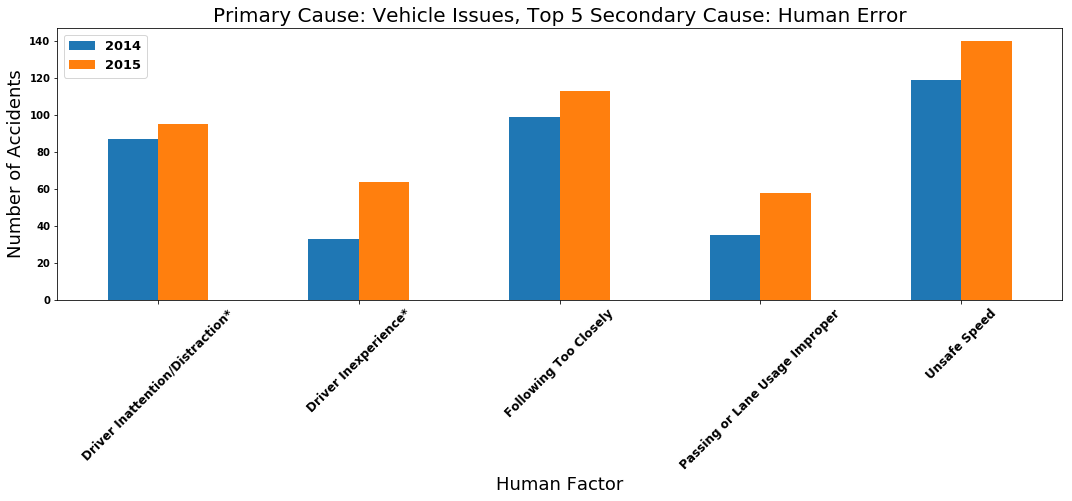

In [85]:
#vehicle5 Vehicle vs Human
# Graph plot for Primary cause of accident as Vehicle Factor and secondary cause as human factor
#plotting top 5 human factors

vehicle_vs_human = vehicle_vs_human_3yrs_list.plot(kind = "bar", figsize = (18,5), align = "center", legend = [])
plt.xlabel("Human Factor", fontsize=18)
plt.ylabel("Number of Accidents", fontsize=18)
plt.tick_params(axis='x', labelsize= 12, rotation=45 )
plt.title("Primary Cause: Vehicle Issues, Top 5 Secondary Cause: Human Error", fontsize=20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.05))
plt.legend(vehicle_vs_envmt_3yrs_list["action_prior_to_accident"],loc="upper left",**hsfont)
vehicle_vs_human
plt.savefig("Vehicle_Issues_And_Human_Error.png")

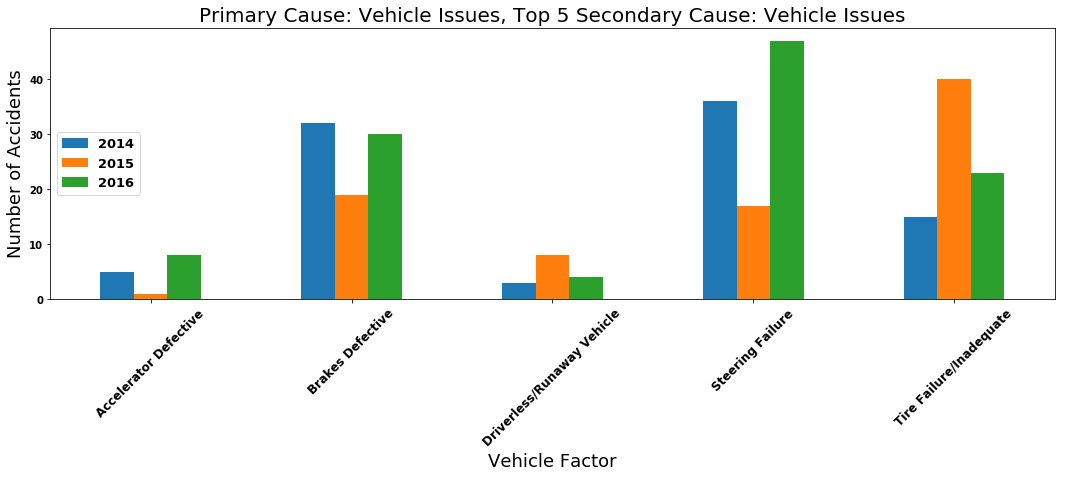

In [86]:
#vehicle5 Vehicle vs Vehicle
# Graph plot for Primary cause of accident as Vehicle Factor and secondary cause also Vehicle factor
#plotting top 5 Vehicle factors

vehicle_vs_vehicle = vehicle_vs_vehicle_3yrs_list.plot(kind = "bar", figsize = (18,5), align = "center", legend = [])
plt.xlabel("Vehicle Factor", fontsize=18)
plt.ylabel("Number of Accidents", fontsize=18)
plt.tick_params(axis='x', labelsize= 12, rotation=45 )
plt.title("Primary Cause: Vehicle Issues, Top 5 Secondary Cause: Vehicle Issues", fontsize = 20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.05))
plt.legend(vehicle_vs_envmt_3yrs_list["action_prior_to_accident"],loc="center left",**hsfont)
#bbox_to_anchor=(0.0, 1.3),
vehicle_vs_vehicle
plt.savefig("Vehicle_Issues_And_Vehicle_Cause.png")

In [87]:
# Environment
accidents_env=cleanseddata[cleanseddata["contributing_factor_1"] == "ENVMT"]


In [88]:
# Environment 1
#Filter the data-set where primary cause of accident was Environmental factor.
# Then those accidents have been grouped by the description and top 10 causes are considered for the purpose of plotting


environment_df = accidents_env[accidents_env["contributing_factor_1"] == "ENVMT"].groupby("contributing_factor_1_description", sort = True).count()
environment_df.drop(list(environment_df.columns)[1:17], axis = 1, inplace = True)
#environment_df

#Filter the data-set where primary cause of accident is Environmental factor.
# Identify top 10 car brands that have had maximum accidents due to those factors.

# Environment 1a
environment_vehicle_df = vehiclecleansed[vehiclecleansed["contributing_factor_1"] == "ENVMT"].groupby("vehicle_make", sort = True).count()
environment_vehicle_df.drop(list(environment_vehicle_df.columns)[1:17], axis = 1, inplace = True)
environment_vehicle_df.sort_values("action_prior_to_accident", ascending = False, inplace = True)
environment_vehicle_df = environment_vehicle_df.head(10)
environment_vehicle_df.columns = ["Accident_Count"]




In [89]:
# Graph work from here
environment_df.reset_index(inplace = True)
environment_df.columns = ["Environment_Factor", "Accident_Count"]


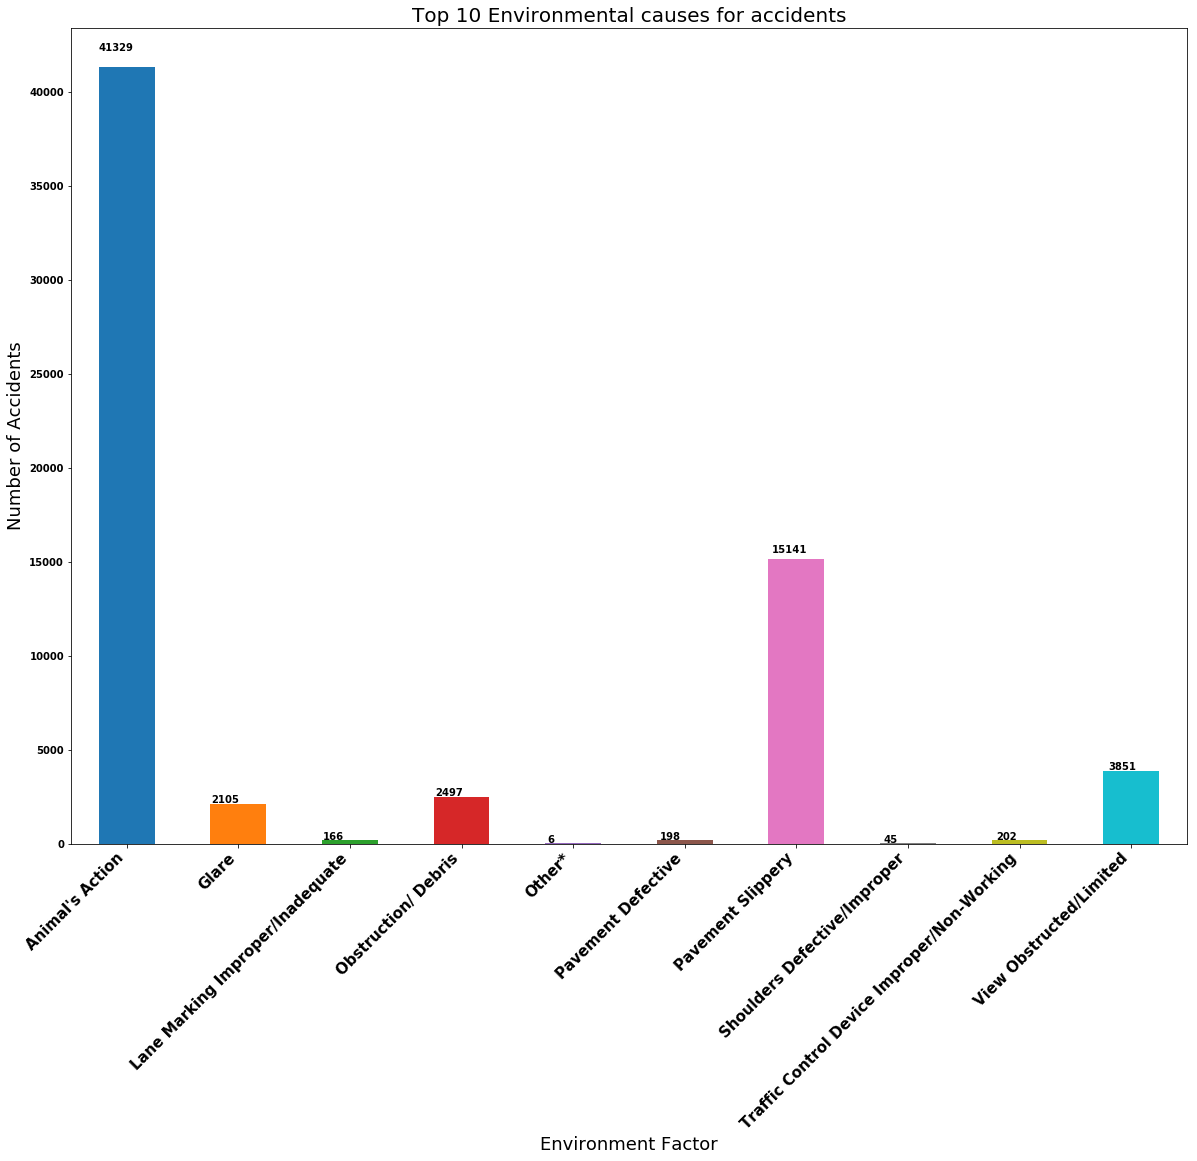

In [90]:
# Plot for top 10 environmental causes for accidents.
fig, ax = plt.subplots()
environment_bar = environment_df.plot(x = "Environment_Factor",
                                      y = "Accident_Count",
                                      kind = "bar", 
                                      figsize = (20,15), 
                                      align = "center", 
                                      ax=plt.gca(), 
                                      legend = [])
plt.xlabel("Environment Factor", fontsize=18)
plt.ylabel("Number of Accidents", fontsize=18)
plt.tick_params(axis='x', rotation = 45, labelsize = 15)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right" )
plt.title("Top 10 Environmental causes for accidents", fontsize=20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.021))

plt.savefig("Top_10_Environmental_causes_for_accidents.png")

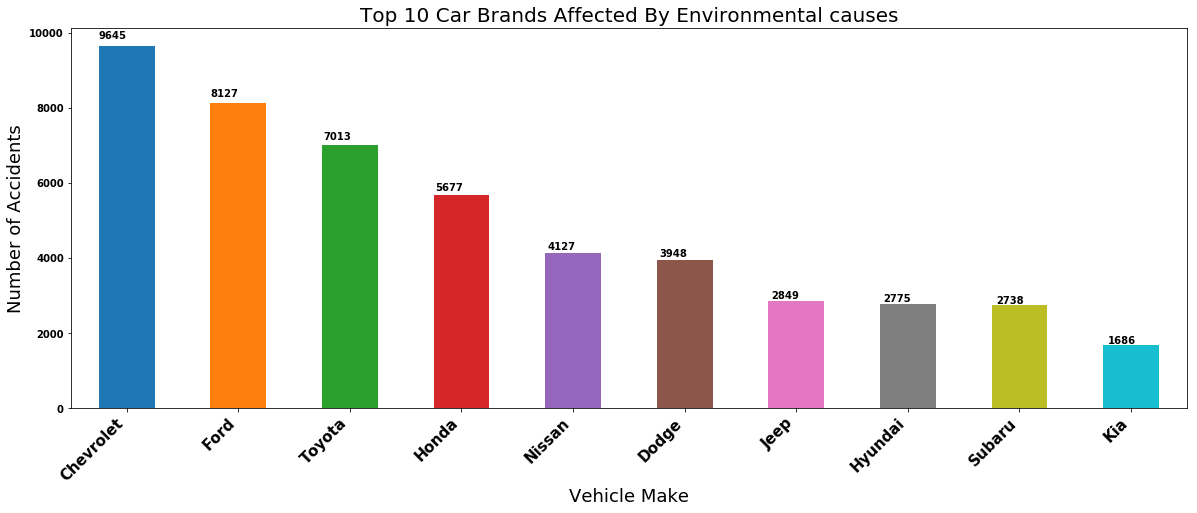

In [91]:
# Graph plot for top 10 vehicle makes getting impacted by those Environmental factor as primary cause
environment_vehicle_df.reset_index(inplace = True)
fig, ax = plt.subplots()
environment_vehicle_bar = environment_vehicle_df.plot(x = "vehicle_make", 
                                      y = "Accident_Count", 
                                      kind = "bar", 
                                      figsize = (20,7), 
                                      align = "center", 
                                      ax=plt.gca(), 
                                      legend = [])
plt.xlabel("Vehicle Make", fontsize=18)
plt.ylabel("Number of Accidents", fontsize=18)
plt.tick_params(axis='x', rotation = 45, labelsize = 15)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right" )
plt.title("Top 10 Car Brands Affected By Environmental causes", fontsize=20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.021))
environment_vehicle_bar
plt.savefig("Top_10_Car_Brands_Affected_By_Environmental_causes.png")

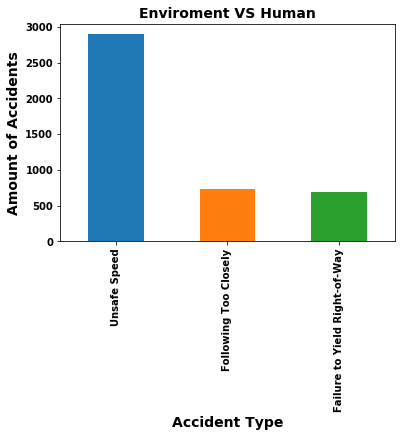

In [92]:
#Filter and get value counts for E v. H

x1 = accidents_env.loc[accidents_env["contributing_factor_2"] == "HUMAN"]
x2 = x1.loc[x1["contributing_factor_2_description"] != "Not Applicable"]
env_hum = x2["contributing_factor_2_description"].value_counts().nlargest(3)
#Create plot and save fig
bar1 = env_hum.plot(kind='bar')
csfont ={'fontweight': 'bold','fontsize': '14'}
bar1.set_xlabel("Accident Type",**csfont)
bar1.set_ylabel("Amount of Accidents",**csfont)
plt.title("Enviroment VS Human",**csfont)
plt.savefig("EnviromentvsHuman")

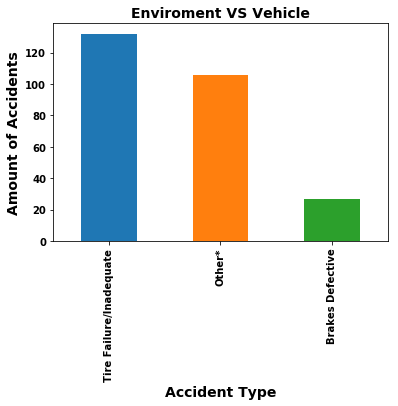

In [93]:
#Filter and get value counts for E v. V

y1 = accidents_env.loc[accidents_env["contributing_factor_2"] == "VEHICLE"]
env_veh = y1["contributing_factor_2_description"].value_counts().nlargest(3)
#Create chart and save fig
bar2 = env_veh.plot(kind='bar')
csfont ={'fontweight': 'bold','fontsize': '14'}
bar2.set_xlabel("Accident Type",**csfont)
bar2.set_ylabel("Amount of Accidents",**csfont)
plt.title("Enviroment VS Vehicle",**csfont)
plt.savefig("EnviromentvsVehicle")

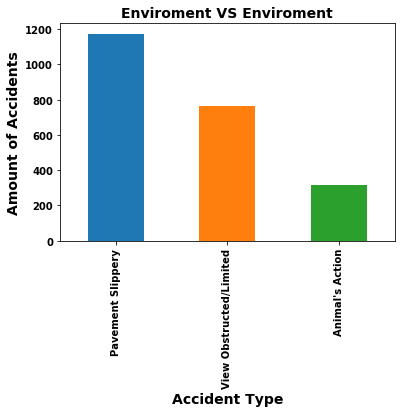

In [94]:
#Filter and get value counts for E v. E

z1 = accidents_env.loc[accidents_env["contributing_factor_2"] == "ENVMT"]
env_env = z1["contributing_factor_2_description"].value_counts().nlargest(3)
#Create chart and save fig
bar3 = env_env.plot(kind='bar')
csfont ={'fontweight': 'bold','fontsize': '14'}
bar3.set_xlabel("Accident Type",**csfont)
bar3.set_ylabel("Amount of Accidents",**csfont)
plt.title("Enviroment VS Enviroment",**csfont)
plt.savefig("EnviromentvsEnviroment")